In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
from torch.utils.data import Subset
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:5


In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Define data transformations (you can customize these as needed)
transform = transforms.Compose([
    transforms.Resize((224,224)),  # Resize the images to a common size
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image data
])
# Replace 'data_dir' with the path to your dataset folder
data_dir = '/raid/ee-mariyam/maryam/ayush/TiH data'

# Load the dataset
dataset = ImageFolder(root=data_dir, transform=transform)
# Define the percentage split for train, validation, and test
train_percentage = 0.50
val_percentage = 0.25
test_percentage = 0.25

# Calculate the sizes of each split
num_data = len(dataset)
num_train = int(train_percentage * num_data)
num_val = int(val_percentage * num_data)
num_test = num_data - num_train - num_val

# Use random_split to split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [num_train, num_val, num_test], generator=torch.Generator().manual_seed(42))
# Define batch size for data loaders
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)


In [3]:
print(len(train_loader))

32


In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from timm.models import create_model
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor

def to_tensor(img):
    transform_fn = Compose([Resize(249, 3), CenterCrop(224), ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    return transform_fn(img)

def show_img(img):
    img = np.asarray(img)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def show_img2(img1, img2, alpha=0.8):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(5, 5))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

def my_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

/raid/ee-mariyam/maryam/miniconda3/envs/ayush/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import time

model = create_model('deit_small_distilled_patch16_224', pretrained=True)
model.classifier = nn.Linear(1000, 3)
num_classes = 3 # Change this according to your dataset
# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Fine-tune the model
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10
training_start_time = time.time()
training_loss = []
validation_loss = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        # logits = outputs.logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    training_loss.append(train_loss)
    train_accuracy = 100 * correct_predictions / total_predictions

    # print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Train Accuracy: {train_accuracy:.2f}%")
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_correct_predictions = 0
    val_total_predictions = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_total_predictions += val_labels.size(0)
            val_correct_predictions += (val_predicted == val_labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    validation_loss.append(val_loss)
    val_accuracy = 100 * val_correct_predictions / val_total_predictions
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))

Epoch 1/10, Train Loss: 0.8583, Train Accuracy: 83.53%, Val Loss: 0.0942, Val Accuracy: 97.22%
Epoch 2/10, Train Loss: 0.0275, Train Accuracy: 99.21%, Val Loss: 0.0291, Val Accuracy: 99.01%
Epoch 3/10, Train Loss: 0.0054, Train Accuracy: 99.70%, Val Loss: 0.0120, Val Accuracy: 99.60%
Epoch 4/10, Train Loss: 0.0005, Train Accuracy: 100.00%, Val Loss: 0.0068, Val Accuracy: 99.60%
Epoch 5/10, Train Loss: 0.0002, Train Accuracy: 100.00%, Val Loss: 0.0074, Val Accuracy: 99.60%
Epoch 6/10, Train Loss: 0.0002, Train Accuracy: 100.00%, Val Loss: 0.0073, Val Accuracy: 99.60%
Epoch 7/10, Train Loss: 0.0001, Train Accuracy: 100.00%, Val Loss: 0.0075, Val Accuracy: 99.60%
Epoch 8/10, Train Loss: 0.0001, Train Accuracy: 100.00%, Val Loss: 0.0078, Val Accuracy: 99.60%
Epoch 9/10, Train Loss: 0.0001, Train Accuracy: 100.00%, Val Loss: 0.0076, Val Accuracy: 99.60%
Epoch 10/10, Train Loss: 0.0001, Train Accuracy: 100.00%, Val Loss: 0.0076, Val Accuracy: 99.60%
Training finished, took 508.66s


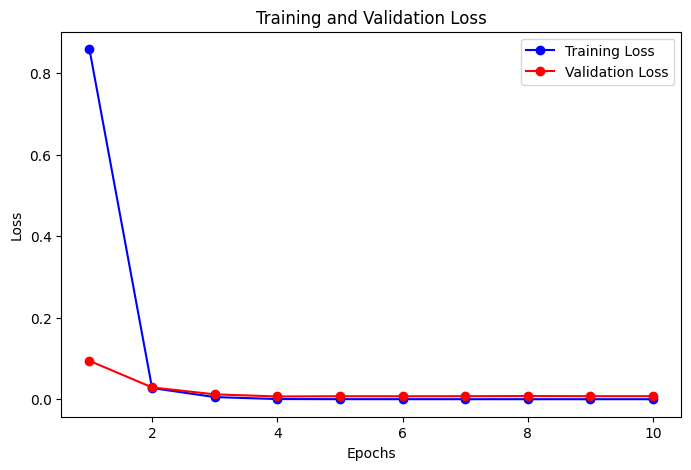

In [6]:
import matplotlib.pyplot as plt

# Define the x-axis (epochs)
epochs = range(1, len(training_loss) + 1)

# Create a figure and plot the training loss and validation loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

In [7]:
torch.save(model, '/raid/ee-mariyam/maryam/ayush/models/DeiT_for_Onion_BR_IYSV_Thrips-50-25-25.h5')

In [24]:
model=torch.load('/raid/ee-mariyam/maryam/ayush/models/DeiT_for_Onion_BR_IYSV_ThripsInsect_Thrips_Symptoms.h5')

In [8]:
model.eval()

correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

test_accuracy = 100 * correct_predictions / total_predictions
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 99.80%


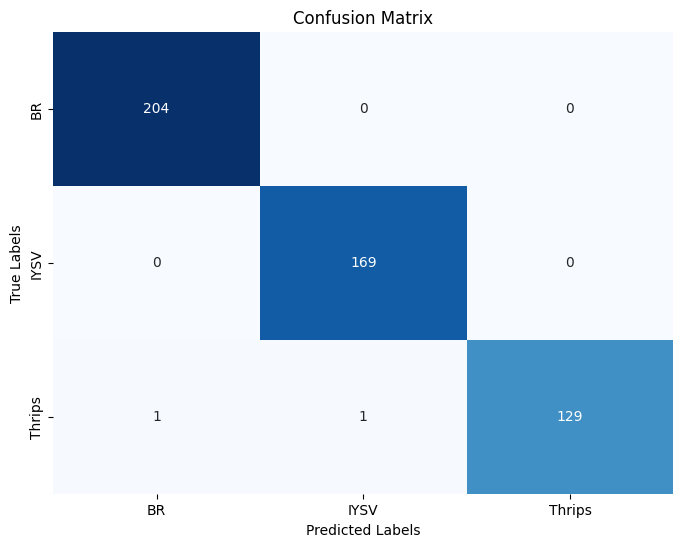

In [9]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:  # Replace 'dataloader' with your data loader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Assuming a classification task with class indices
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
conf_matrix = confusion_matrix(all_labels, all_predictions)
# Plot the confusion matrix as a heatmap
class_names = ["BR", "IYSV", "Thrips"] 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


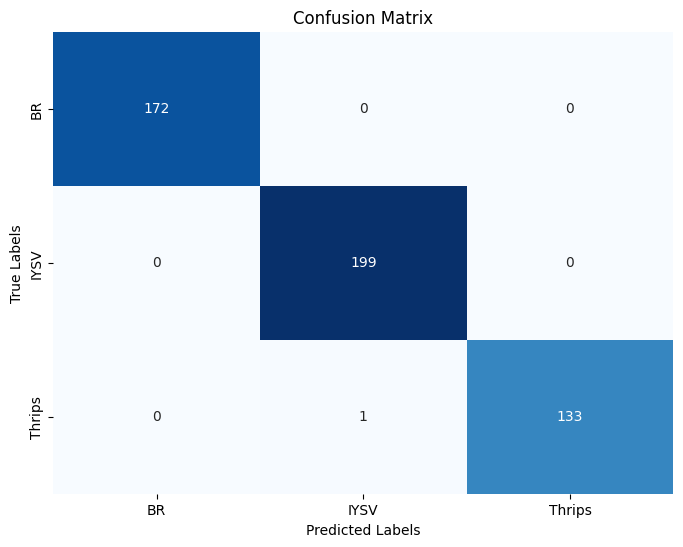

In [10]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:  # Replace 'dataloader' with your data loader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Assuming a classification task with class indices
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
conf_matrix = confusion_matrix(all_labels, all_predictions)
# Plot the confusion matrix as a heatmap
class_names = ["BR", "IYSV", "Thrips"] 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


tensor(0, device='cuda:5')


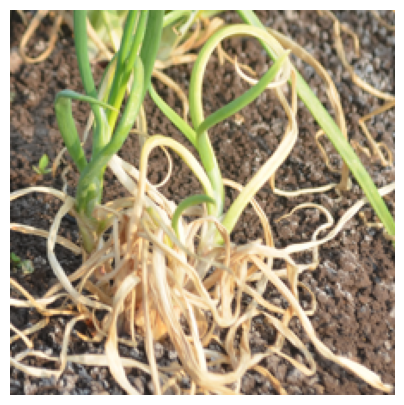

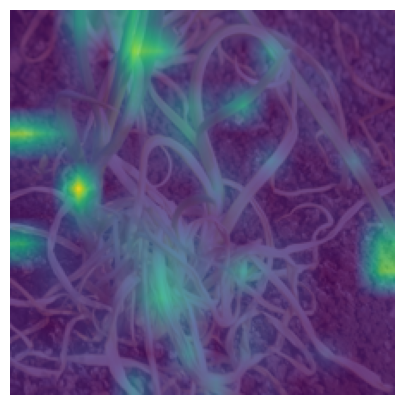

In [11]:
img = Image.open('/raid/ee-mariyam/maryam/ayush/TiH data/Bulb_Rot/BR E5 P1 E (0070) - 24 Jan.JPG')
x = to_tensor(img).to(device)
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)
y = model(x.unsqueeze(0))
attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)
softmax = torch.nn.Softmax(dim=1)
probs = softmax(y)
predicted_class = torch.argmax(probs)
print(predicted_class)
show_img(img_resized.cpu())
show_img2(img_resized.cpu(), cls_resized.cpu(), alpha=0.8)

tensor(2, device='cuda:5')


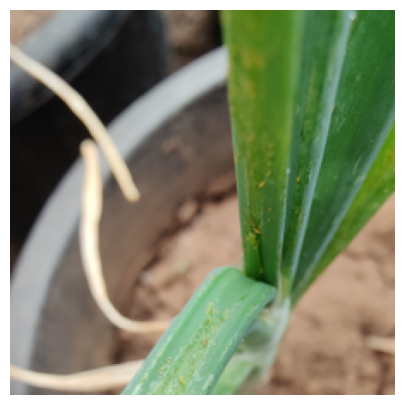

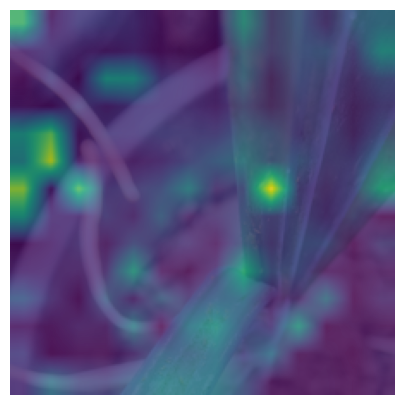

In [12]:
img = Image.open('/raid/ee-mariyam/maryam/ayush/TiH data/Thrips/TH (I)  IMG20230213121350 (2)  FEB 27.jpg')
x = to_tensor(img).to(device)
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)
y = model(x.unsqueeze(0))
attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)
softmax = torch.nn.Softmax(dim=1)
probs = softmax(y)
predicted_class = torch.argmax(probs)
print(predicted_class)
# show_img(img)
# show_img(attn_map)
# show_img(cls_weight)
show_img(img_resized.cpu())
show_img2(img_resized.cpu(), cls_resized.cpu(), alpha=0.8)

tensor(2, device='cuda:5')


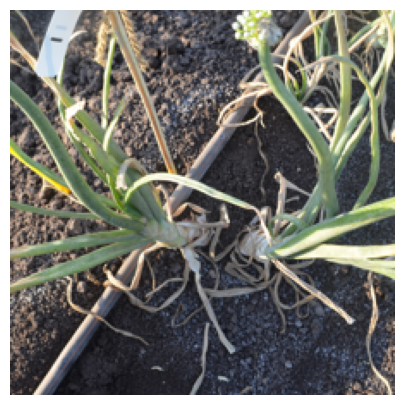

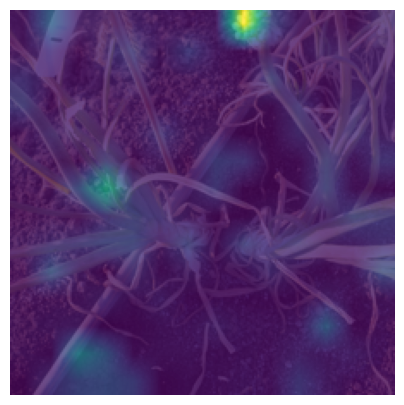

In [13]:
img = Image.open('/raid/ee-mariyam/maryam/ayush/TiH data/Thrips/TH B1  DSC_0131  FEB 27.JPG')
x = to_tensor(img).to(device)
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)
y = model(x.unsqueeze(0))
attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)
softmax = torch.nn.Softmax(dim=1)
probs = softmax(y)
predicted_class = torch.argmax(probs)
print(predicted_class)
# show_img(img)
# show_img(attn_map)
# show_img(cls_weight)
show_img(img_resized.cpu())
show_img2(img_resized.cpu(), cls_resized.cpu(), alpha=0.8)

tensor(1, device='cuda:5')


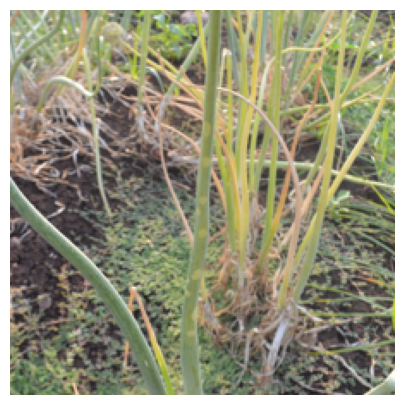

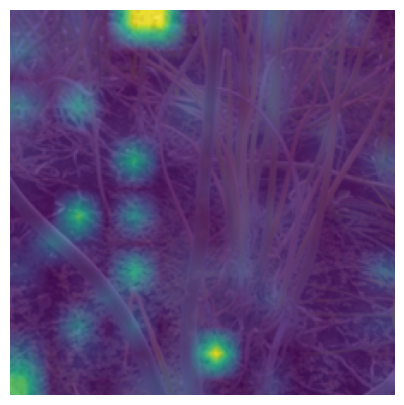

In [14]:
img = Image.open('/raid/ee-mariyam/maryam/ayush/TiH data/IYSV/IYSV E5 DSC_0016 APR 18.JPG')
x = to_tensor(img).to(device)
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)
y = model(x.unsqueeze(0))
attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)
softmax = torch.nn.Softmax(dim=1)
probs = softmax(y)
predicted_class = torch.argmax(probs)
print(predicted_class)
# show_img(img)
# show_img(attn_map)
# show_img(cls_weight)
show_img(img_resized.cpu())
show_img2(img_resized.cpu(), cls_resized.cpu(), alpha=0.8)

tensor(1, device='cuda:5')


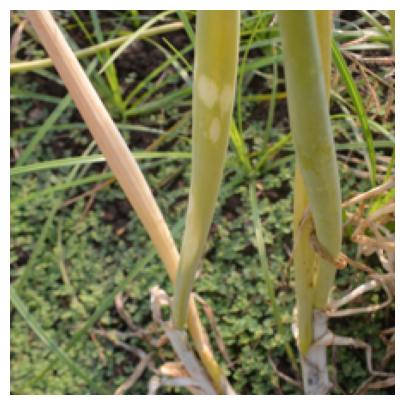

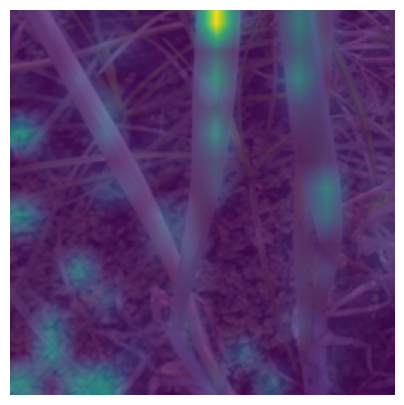

In [15]:
img = Image.open('/raid/ee-mariyam/maryam/ayush/TiH data/IYSV/IYSV E5 DSC_0006 APR 18.JPG')
x = to_tensor(img).to(device)
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)
y = model(x.unsqueeze(0))
attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)
softmax = torch.nn.Softmax(dim=1)
probs = softmax(y)
predicted_class = torch.argmax(probs)
print(predicted_class)
# show_img(img)
# show_img(attn_map)
# show_img(cls_weight)
show_img(img_resized.cpu())
show_img2(img_resized.cpu(), cls_resized.cpu(), alpha=0.8)

tensor(2, device='cuda:5')


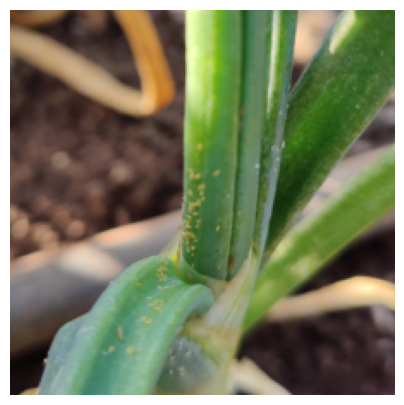

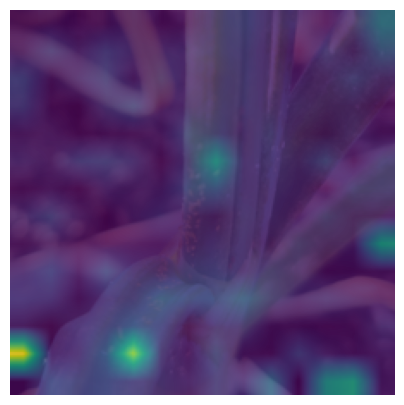

In [16]:
img = Image.open('/raid/ee-mariyam/maryam/ayush/TiH data/Thrips/TH (I) D2 IMG20230215171735 FEB 14.jpg')
x = to_tensor(img).to(device)
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)
y = model(x.unsqueeze(0))
attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)
softmax = torch.nn.Softmax(dim=1)
probs = softmax(y)
predicted_class = torch.argmax(probs)
print(predicted_class)
# show_img(img)
# show_img(attn_map)
# show_img(cls_weight)
show_img(img_resized.cpu())
show_img2(img_resized.cpu(), cls_resized.cpu(), alpha=0.8)

tensor(1, device='cuda:5')


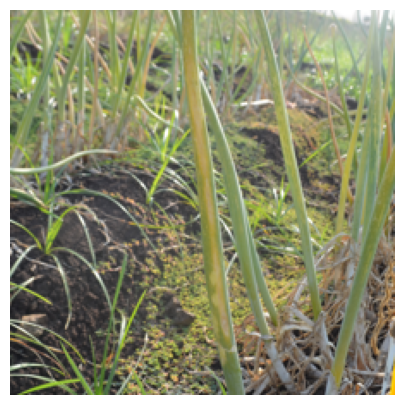

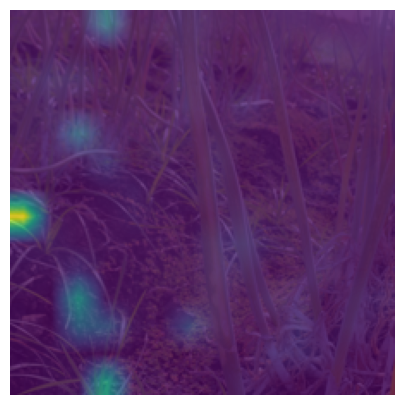

In [17]:
img = Image.open('/raid/ee-mariyam/maryam/ayush/TiH data/IYSV/IYSV E5 DSC_0083 APR 21.JPG')
x = to_tensor(img).to(device)
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)
y = model(x.unsqueeze(0))
attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)
softmax = torch.nn.Softmax(dim=1)
probs = softmax(y)
predicted_class = torch.argmax(probs)
print(predicted_class)
# show_img(img)
# show_img(attn_map)
# show_img(cls_weight)
show_img(img_resized.cpu())
show_img2(img_resized.cpu(), cls_resized.cpu(), alpha=0.8)

In [18]:
print(model)

VisionTransformerDistilled(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): 